# About

## Author

    Thiago Luis Rodrigues Pinho @AILAB 

## Start Date

    30/04/2020

## Objectives

    Use an LDA components analysis for text documents and then evaluate their
    similarities using Jensen-Shannon Distance

## Summary

    1. Loading data
    2. Treating Data
    3. Generating LDA Component Analysis
        3.1 Generating Topics
    4. Similarity Jensen-Shannon
        4.1 Creating Topics Similarities Pairs
        4.2 Generating Heatmap for Text Similarities
    5. Bibliography




# [ALEI] IAgrupador LDA with Jensen-Shannon distance

In [2]:
from time import time

import gensim
from gensim import corpora, models
from fastparquet import write
from scipy.spatial import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set()

unable to import 'smart_open.gcs', disabling that module


## 1. Loading data

In [3]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"

filename = "data_preprocessed"

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        2036 non-null   object
 1   process_id  2036 non-null   object
dtypes: object(2)
memory usage: 31.9+ KB
None
CPU times: user 2.83 s, sys: 116 ms, total: 2.94 s
Wall time: 2.95 s


## 2. Treating Data

In [4]:
num_samples = 100
sample_df = ailab_df.sample(n=num_samples)
sample_df = sample_df.drop_duplicates(subset='process_id')
sample_df['tokenized_docs'] = [ document_text.split() for document_text in sample_df['text'].to_list()]
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1589 to 1761
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        90 non-null     object
 1   process_id  90 non-null     object
dtypes: object(2)
memory usage: 2.1+ KB
None


## 3. Generating LDA Component Analysis

In [6]:
tokenized_docs = sample_df['tokenized_docs'].to_list()
# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

### 3.1 Generating Topics

In [39]:
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]
NUM_TOPICS = 10
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.012*"beneficio" + 0.011*"autora" + 0.009*"parcelas" + 0.009*"monetaria" + 0.008*"correcao" + 0.007*"aposentadoria" + 0.007*"hora" + 0.006*"juizado" + 0.006*"ST_LEI_909995" + 0.006*"antonio"
Topic: 1 Word: 0.022*"evento" + 0.012*"prazo" + 0.011*"prescricao" + 0.010*"separacao" + 0.010*"pagina" + 0.009*"calculo" + 0.008*"servidores" + 0.007*"aposentadoria" + 0.006*"base" + 0.006*"abril"
Topic: 2 Word: 0.012*"agravante" + 0.009*"agravo" + 0.009*"extraordinario" + 0.008*"concessao" + 0.008*"tributario" + 0.007*"cofins" + 0.006*"republica" + 0.006*"ministerio" + 0.006*"evento" + 0.006*"simples"
Topic: 3 Word: 0.014*"certidao" + 0.009*"santa" + 0.009*"extraordinario" + 0.008*"trabalho" + 0.008*"original" + 0.007*"estadual" + 0.007*"jose" + 0.007*"repercussao" + 0.007*"presentes" + 0.006*"inconstitucionalidade"
Topic: 4 Word: 0.009*"servicos" + 0.009*"informacoes" + 0.009*"brasil" + 0.007*"maria" + 0.007*"beneficios" + 0.007*"sumula" + 0.006*"estadual" + 0.006*"documento" + 0

In [40]:
corpus_tfidf = tfidf[doc_term_matrix]
probabilities = lda_model_tfidf[corpus_tfidf]
same_shape_probabilities = []
for topics_probability_list in probabilities:
    topics_probability_dict = dict()
    for index, score in topics_probability_list:
        topics_probability_dict[index] = score
    if len(topics_probability_dict) < NUM_TOPICS:
        for i in range(NUM_TOPICS):
            if i not in topics_probability_dict:
                topics_probability_dict[i] = 0.0
    same_shape_probabilities.append([topics_probability_dict[key] for key in sorted(topics_probability_dict.keys())])
sample_df['topics_similarity'] = same_shape_probabilities
sample_df

,text,process_id,tokenized_docs,topics_similarity
1589,santa catarina justica gratuita judiciario com...,812651,"[santa, catarina, justica, gratuita, judiciari...","[0.314692, 0.011617217, 0.011613116, 0.0116179..."
1976,conclusao efeitos ciclo avaliacao refere ST_AR...,948147,"[conclusao, efeitos, ciclo, avaliacao, refere,...","[0.06781662, 0.47726712, 0.01060735, 0.0106125..."
1989,judiciario juizados especiais federais secao j...,740312,"[judiciario, juizados, especiais, federais, se...","[0.012758146, 0.8851853, 0.012756419, 0.012757..."
742,afrremo tribunal hederal comunicacao eletronic...,1065463,"[afrremo, tribunal, hederal, comunicacao, elet...","[0.02316627, 0.02316683, 0.023166431, 0.023171..."
1293,judiciario secao judiciaria distrito federal s...,740297,"[judiciario, secao, judiciaria, distrito, fede...","[0.7786005, 0.1276146, 0.011720315, 0.01172205..."
...,...,...,...,...
382,termo recebimento autuacao rectes breda logist...,1152046,"[termo, recebimento, autuacao, rectes, breda, ...","[0.017574769, 0.017579027, 0.017579475, 0.2436..."
677,pagina separacao gerada automaticamente evento...,717806,"[pagina, separacao, gerada, automaticamente, e...","[0.0346154, 0.034627132, 0.034618724, 0.034619..."
183,isanco brasil page a33b201304850340032 boletos...,995810,"[isanco, brasil, page, a33b201304850340032, bo...","[0.028261075, 0.028259302, 0.02825669, 0.02825..."
1562,recurso vencidos ministros carmen lucia eros g...,1138645,"[recurso, vencidos, ministros, carmen, lucia, ...","[0.0, 0.39530778, 0.0, 0.0, 0.0, 0.0, 0.256142..."


## 4. Similarity Jensen-Shannon

### 4.1 Creating Topics Similarities Pairs
It's necessary to prepare data so each input is a pair os texts and if they are close

In [41]:
%time
text_pairs = []
comparing_same_text = True
for question_1_index, question_1_row in sample_df.iterrows():
    question_1_text = question_1_row['topics_similarity']
    question_1_id = question_1_row['process_id']
    for question_2_index, question_2_row in sample_df.iterrows():
        if not comparing_same_text and question_1_index == question_2_index:
            continue
        question_2_text = question_2_row['topics_similarity']
        question_2_id = question_2_row['process_id']
        text_pairs.append([question_1_id, question_1_text, question_2_id, question_2_text])

pair_text_df = pd.DataFrame(text_pairs, columns=['question1_id', 'question1', 'question2_id', 'question2'])
print(train_df.info())

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 30.3 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  8100 non-null   object
 1   question1     8100 non-null   object
 2   question2_id  8100 non-null   object
 3   question2     8100 non-null   object
dtypes: object(4)
memory usage: 253.2+ KB
None


#### Storing partial results

In [9]:
pair_text_filename = "text_pairs" + str(num_samples)
pair_text_parquet_filename = RELATIVE_FOLDER_PATH + pair_text_filename + ".parquet.gzip"

In [10]:
write(pair_text_parquet_filename, pair_text_df, compression='gzip')

#### Loading partial results

In [11]:
pair_text_df = pd.read_parquet(pair_text_parquet_filename)
print(pair_text_df.head())

  question1_id                                          question1  \
0       789324  documento digitalizado juntado processo usuari...   
1       789324  documento digitalizado juntado processo usuari...   
2       789324  documento digitalizado juntado processo usuari...   
3       789324  documento digitalizado juntado processo usuari...   
4       789324  documento digitalizado juntado processo usuari...   

  question2_id                                          question2  
0       789324  documento digitalizado juntado processo usuari...  
1       824250  estj poper jupiciario tribunal regional federa...  
2       979045  judiciario supremo tribunal federal recibo pet...  
3      1013618  creristton prado advocacia analogia utilizacao...  
4      1131116  discussao inclusao creditos decorrentes contri...  


### 4.2 Generating Heatmap for Text Similarities

In [42]:
unique_ids_list = pair_text_df['question1_id'].unique().tolist()

unique_ids_list.sort()
print(unique_ids_list)

['1007957', '1014726', '1019620', '1022060', '1025170', '1029623', '1032254', '1044164', '1045542', '1051600', '1054421', '1057021', '1062730', '1063182', '1063398', '1064290', '1064395', '1064904', '1065463', '1068651', '1072104', '1074289', '1093208', '1098159', '1105254', '1105731', '1111229', '1112780', '1114399', '1124427', '1125488', '1138645', '1140827', '1141678', '1150777', '1152046', '1152456', '1153380', '1158754', '1160428', '1163239', '637129', '656891', '679912', '682083', '685030', '699579', '699639', '711106', '714139', '714478', '714868', '717806', '726506', '726783', '732856', '740053', '740297', '740312', '740367', '741168', '752486', '763565', '763815', '771941', '772221', '787966', '792243', '792882', '794515', '796201', '799970', '800318', '805395', '811207', '811921', '812651', '815049', '824916', '827996', '916369', '944478', '948147', '972243', '975361', '980526', '980720', '986097', '994604', '995810']


In [43]:
dimension = len(unique_ids_list)
distances_mapped = dict()
for choosen_id in unique_ids_list:
    choosen_question_mask = pair_text_df['question1_id'].values == choosen_id
    compared_df = pair_text_df[choosen_question_mask]
    
    compared_df.sort_values(by=['question2_id'], inplace=True)
    
    compared_ids_list = compared_df['question2_id'].to_list()
    if compared_ids_list != unique_ids_list:
        break
        print("An error ocurred")
    
    predictions_list = []
    for pair_text_index, pair_text_row in compared_df.iterrows():
        row_distance = 1 - distance.jensenshannon(pair_text_row['question1'], pair_text_row['question2'])
        predictions_list.append(row_distance)
    distances_mapped[choosen_id] = predictions_list

/home/dev/PythonEnviroments/ailab-researching/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Reordering rows and columns to improve visualisation

In [44]:
mapped_distances_df = pd.DataFrame.from_dict(distances_mapped, orient='index',
                       columns=unique_ids_list)
mapped_distances_df.head()

,1007957,1014726,1019620,1022060,1025170,1029623,1032254,1044164,1045542,1051600,...,916369,944478,948147,972243,975361,980526,980720,986097,994604,995810
1007957,1.000000,0.331275,0.690107,0.280347,0.256213,0.429230,0.816256,0.409028,0.213686,0.393605,...,0.297076,0.681616,0.534477,0.788116,0.328560,0.267480,0.328347,0.279006,0.618251,0.307542
1014726,0.331275,1.000000,0.558011,0.215538,0.200912,0.602292,0.349116,0.441326,0.279761,0.262025,...,0.385566,0.558849,0.468413,0.251096,0.714296,0.379445,0.460123,0.381967,0.265037,0.233164
1019620,0.690107,0.558011,1.000000,0.233846,0.213889,0.600790,0.727850,0.501685,0.243161,0.399294,...,0.345978,0.806598,0.600212,0.621732,0.491244,0.327639,0.394070,0.334714,0.579418,0.257781
1022060,0.280347,0.215538,0.233846,1.000000,0.269883,0.249332,0.215739,0.507646,0.498132,0.235172,...,0.311622,0.294204,0.299848,0.210859,0.196239,0.281502,0.295124,0.293338,0.215692,0.322116
1025170,0.256213,0.200912,0.213889,0.269883,1.000000,0.225041,0.201038,0.226297,0.215712,0.214733,...,0.283567,0.264884,0.268642,0.197913,0.187231,0.259158,0.265798,0.268755,0.201009,0.292065


In [45]:
first_question_id = unique_ids_list[0]
mapped_distances_df.sort_values(by=[first_question_id], ascending=False, inplace=True)
mapped_distances_df = mapped_distances_df[mapped_distances_df.index]
mapped_distances_df.head()

,1007957,1032254,1098159,972243,699579,717806,711106,714868,763565,799970,...,752486,726783,740367,740297,656891,794515,740312,1025170,815049,1045542
1007957,1.000000,0.816256,0.797018,0.788116,0.785576,0.777540,0.770698,0.766717,0.752650,0.728164,...,0.266802,0.264676,0.263646,0.262551,0.262450,0.261241,0.259153,0.256213,0.254315,0.213686
1032254,0.816256,1.000000,0.657704,0.851871,0.639691,0.630037,0.622558,0.618408,0.645546,0.633180,...,0.207353,0.201062,0.200112,0.200442,0.204724,0.204014,0.202751,0.201038,0.199925,0.167445
1098159,0.797018,0.657704,1.000000,0.714581,0.956329,0.935111,0.919467,0.911042,0.858087,0.817242,...,0.298676,0.303511,0.302870,0.299817,0.293500,0.292045,0.289544,0.286067,0.283806,0.255009
972243,0.788116,0.851871,0.714581,1.000000,0.684991,0.670024,0.658770,0.652637,0.711171,0.697035,...,0.203493,0.197935,0.197091,0.197385,0.201174,0.200550,0.199430,0.197913,0.196928,0.167445
699579,0.785576,0.639691,0.956329,0.684991,1.000000,0.978737,0.963042,0.954585,0.839156,0.800852,...,0.312992,0.320073,0.319530,0.315661,0.307261,0.305666,0.302909,0.299080,0.296580,0.270485


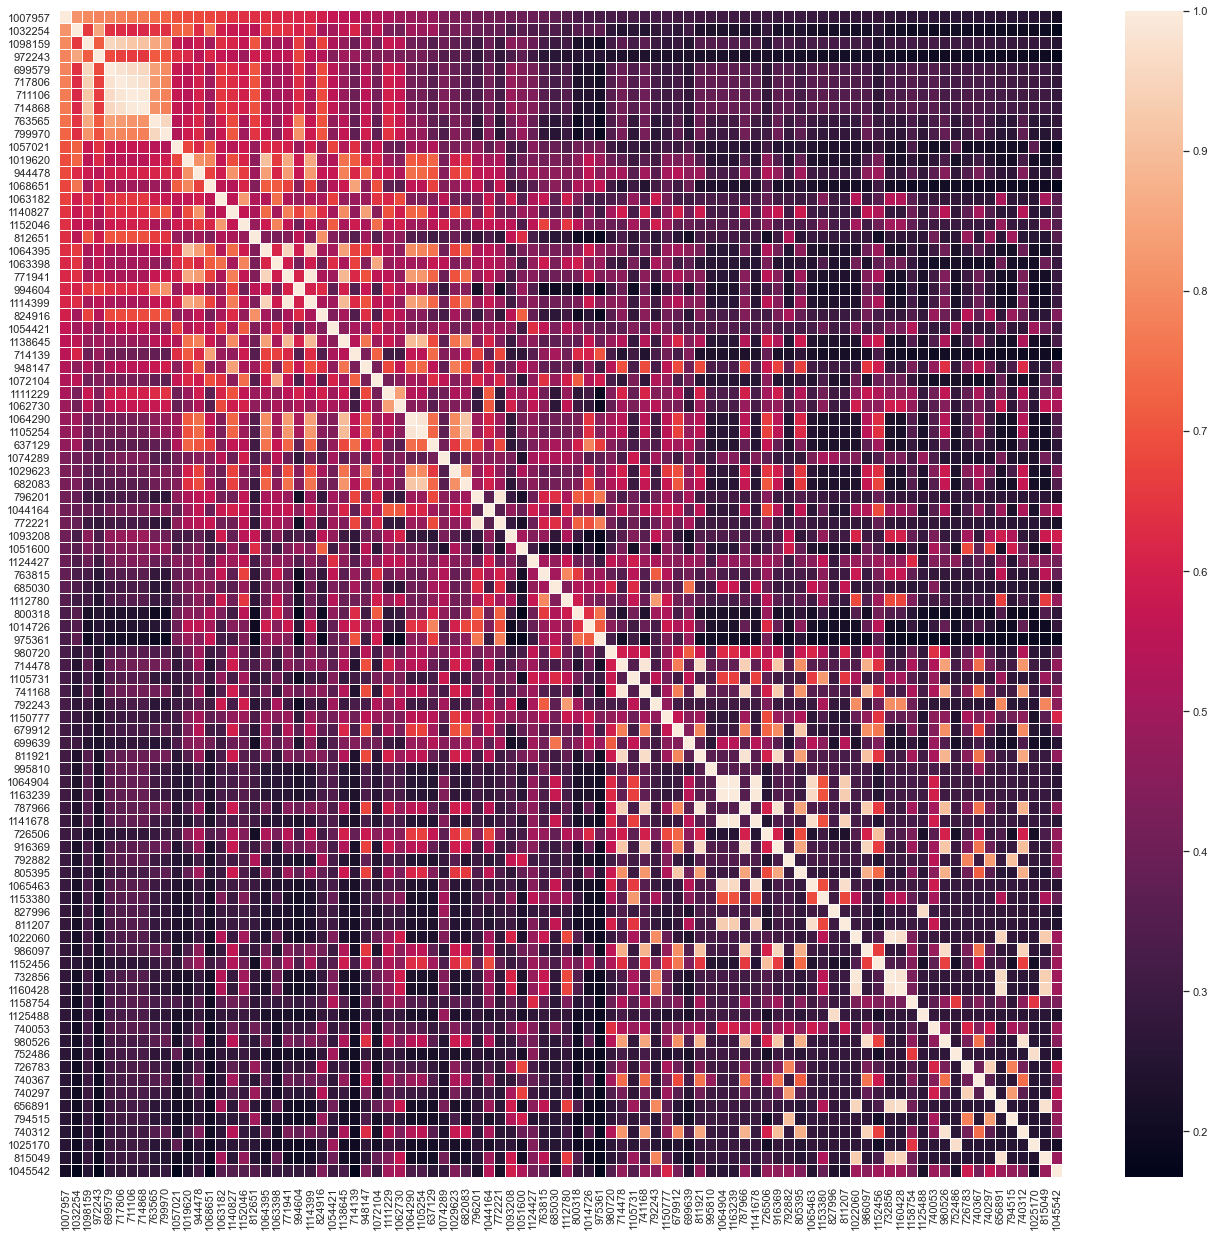

In [47]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mapped_distances_df, linewidths=0.01)

## 5. Bibliography
Topic Modeling and Latent Dirichlet Allocation (LDA) in Python. Susan Li.
[Available at](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24) Last visited: 30/04/2020
